In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/seoul-bike-rental-ai-pro-iti/sample_submission.csv
/kaggle/input/seoul-bike-rental-ai-pro-iti/train.csv
/kaggle/input/seoul-bike-rental-ai-pro-iti/test.csv


In [2]:
# !pip install xgboost



from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

import seaborn as sns

import sklearn
sklearn.__version__

'0.23.2'

# Exploratory Data Analysis

In [3]:
#Reading Train Dataset

df = pd.read_csv(os.path.join('data/train.csv'))
print("The shape of the dataset is {}.\n\n".format(df.shape))

df_test = pd.read_csv(os.path.join('data/test.csv'))
print("The shape of test dataset is {}.\n\n".format(df_test.shape))

df.head()

The shape of the dataset is (5760, 15).


The shape of test dataset is (3000, 14).




,ID,Date,y,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [4]:
# df.info()

In [5]:
# df.drop(columns='ID').describe()

In [6]:
# df.isna().sum()

In [7]:
# df.duplicated().sum()

In [8]:
# # count the values of each column
# for col in df.drop(columns='ID').columns:
#     print(f'For column {col}')
#     print('------------------')
#     print(df[col].value_counts())
#     print('\n')

In [9]:
# corr_matrix = df.corr()
# corr_matrix['y'].sort_values(ascending=False)

In [10]:
# #pairplots to get an intuition of potential correlations
# sns.pairplot(df.drop(columns="ID"), diag_kind="kde")

In [11]:
# df["Temperature(�C)"].corr(df["Dew point temperature(�C)"])

In [12]:
# df.drop(columns= "ID").hist(bins=50, figsize=(20,15))
# plt.show()

In [13]:
# for f in ['Solar Radiation (MJ/m2)', "Seasons", "Hour", "Rainfall(mm)", "Snowfall (cm)", "Wind speed (m/s)", "Humidity(%)", "Functioning Day"]:
#     plt.bar(df[f], df['y'])
#     plt.xlabel(f)
#     plt.ylabel('Number of bikes')
#     plt.show()
#     plt.clf()

# Add Features

Train Data

In [14]:
df["HumidityMultTemp"] = df['Humidity(%)'] * df['Temperature(�C)']
df["HourMultRain"] = df['Hour'] * df['Rainfall(mm)']
df["HourMultTemp"] = df['Hour'] * df['Temperature(�C)']
df["HourMultSnow"] = df['Hour'] * df['Snowfall (cm)']


In [15]:
def add_deviation_feature(X, feature, category):
    # temp groupby object
    category_gb = X.groupby(category)[feature]
    # create category means and standard deviations for each observation
    category_mean = category_gb.transform(lambda x: x.mean())
    category_std = category_gb.transform(lambda x: x.std())
    # compute stds from category mean for each feature value,
    # add to X as new feature
    deviation_feature = (X[feature] - category_mean) / category_std 
    X[feature + 'Dev' + category] = deviation_feature

add_deviation_feature(df,'Solar Radiation (MJ/m2)' , "Hour")
add_deviation_feature(df,'HumidityMultTemp' , "Hour")
df.fillna(0, inplace=True)


In [16]:
#Convert Date to Year, Month, Day
date_col = pd.to_datetime(df['Date']).dt

df["Year"] = date_col.year
df["Month"] = date_col.month
df["Day"] = date_col.day

#Replace Date With Week Day 
dw_mapping={
    0: 'Monday', 
    1: 'Tuesday', 
    2: 'Wednesday', 
    3: 'Thursday', 
    4: 'Friday',
    5: 'Saturday', 
    6: 'Sunday'
} 
df['Day_name'] = date_col.weekday.map(dw_mapping)
df.drop(columns="Date", inplace=True)
# df.head()

In [17]:
df["Weekend"] = df['Day_name'].apply(lambda x : 1 if (x == 'Saturday' or x == "Sunday") else(0))

In [18]:
def get_cat_hour(df):
    cat_hour = []
    for hour in df['Hour']:
        if hour <8: cat_hour.append(1)
        elif hour == 8 :  cat_hour.append(4)
        elif hour == 9 : cat_hour.append(5)
        elif hour < 18 : cat_hour.append(3)
        elif hour==18 or hour==19 : cat_hour.append(7)
        elif hour==20 or hour==21 : cat_hour.append(6)
        else: cat_hour.append(2)
    df["cat_hour"] = cat_hour
    
    
def get_cat_temp(df):
    cat_temp = []
    for t in df['Temperature(�C)']:
        if t < 0: cat_temp.append(1)
        elif t < 20 : cat_temp.append(2)
        elif t < 35 : cat_temp.append(3)
        else : cat_temp.append(4)
    df["cat_temp"] = cat_temp 
    
def get_mean_of_y(feature):
    meanOfy_dict = {}
    grouped = df.groupby(feature)
    for key,item in grouped:
        a_group = grouped.get_group(key)
        meanOfy_dict[key] = round(a_group["y"].mean())
    return meanOfy_dict

    
    
get_cat_hour(df)
get_cat_temp(df)

meanOfy_dict = get_mean_of_y("cat_hour")   
meanyvt_dict = get_mean_of_y("cat_temp")
meanyvm_dict = get_mean_of_y("Month")
meanyvy_dict = get_mean_of_y("Year")
    
    
df["meanyvt"] = [meanyvt_dict[temp] for temp in df["cat_temp"]]
df["meanOfy"] = [meanOfy_dict[hour] for hour in df["cat_hour"]]

df["meanyvm"] = [meanyvm_dict[month] for month in df["Month"]]
df["meanyvy"] = [meanyvy_dict[year] for year in df["Year"]]


df["xxx"] = df["meanyvt"] * df["HumidityMultTemp"] * df["HumidityMultTempDevHour"]


Test Data

In [19]:
df_test["HumidityMultTemp"] = df_test['Humidity(%)'] * df_test['Temperature(�C)']
df_test["HourMultRain"] = df_test['Hour'] * df_test['Rainfall(mm)']
df_test["HourMultTemp"] = df_test['Hour'] * df_test['Temperature(�C)']
df_test["HourMultSnow"] = df_test['Hour'] * df_test['Snowfall (cm)']


In [20]:
add_deviation_feature(df_test,'Solar Radiation (MJ/m2)' , "Hour")
add_deviation_feature(df_test,'HumidityMultTemp' , "Hour")
df_test.fillna(0, inplace=True)

In [21]:
#Convert Date to Year, Month, Day
date_col = pd.to_datetime(df_test['Date']).dt

df_test["Year"] = date_col.year
df_test["Month"] = date_col.month
df_test["Day"] = date_col.day

#Replace Date With Week Day 
dw_mapping={
    0: 'Monday', 
    1: 'Tuesday', 
    2: 'Wednesday', 
    3: 'Thursday', 
    4: 'Friday',
    5: 'Saturday', 
    6: 'Sunday'
} 
df_test['Day_name'] = date_col.weekday.map(dw_mapping)
df_test.drop(columns="Date", inplace=True)

In [22]:
df_test["Weekend"] = df_test['Day_name'].apply(lambda x : 1 if (x == 'Saturday' or x == "Sunday") else(0))

In [23]:

get_cat_hour(df_test)
get_cat_temp(df_test)

df_test["meanyvt"] = [meanyvt_dict[temp] for temp in df_test["cat_temp"]]
df_test["meanOfy"] = [meanOfy_dict[hour] for hour in df_test["cat_hour"]]

df_test["meanyvm"] = [meanyvm_dict[month] for month in df_test["Month"]]
df_test["meanyvy"] = [meanyvy_dict[year] for year in df_test["Year"]]


df_test["xxx"] = df_test["meanyvt"] * df_test["HumidityMultTemp"] * df_test["HumidityMultTempDevHour"]


# Drop Columns

Train Data

In [24]:
dropped_col = ["HumidityMultTemp", "cat_temp", "cat_hour","Temperature(�C)", "Dew point temperature(�C)"]
df.drop(columns=dropped_col, inplace=True)

In [25]:
df = df[df["Functioning Day"] == "Yes"]
df.drop(columns=["Functioning Day"], inplace=True)
df.reset_index(drop=True, inplace=True)

Test Data

In [26]:
df_test.drop(columns= dropped_col, inplace=True)

In [27]:
# df_test_yes = df_test_using_ord_enc[df_test_using_ord_enc["Functioning Day"] == 1]
# df_test.drop(columns=["Functioning Day"], inplace=True)

# Encode Data

Train data

In [28]:
df["Visibility"]=df['Visibility (10m)'].apply(lambda x : 1 if (x >650) else(0))
df.drop(columns=['Visibility (10m)'], inplace=True)

# df["Humidity"]=df['Humidity(%)'].apply(lambda x : 0 if (x > 35 and x < 70) else(1))
# df.drop(columns=['Humidity(%)'], inplace=True)

df["Snowfall"]=df['Snowfall (cm)'].apply(lambda x : 1 if (x > 0) else(0))
df.drop(columns=['Snowfall (cm)'], inplace=True)

df['Rainfall']=df['Rainfall(mm)'].apply(lambda x : 1 if (x > 0) else(0))
df.drop(columns=['Rainfall(mm)'], inplace=True)

In [29]:
enc_col_names = ["Visibility", "Day_name", "Seasons", "Holiday"]
enc_df = df[enc_col_names]
df.drop(enc_col_names, inplace=True, axis=1)
# enc_df.head()

In [30]:
# Ordinal Encoding
ord_enc = preprocessing.OrdinalEncoder(dtype=int)
ord_enc_df = pd.DataFrame(ord_enc.fit_transform(enc_df), columns= enc_col_names)
# ord_enc_df.head()

In [31]:
df_using_ord_enc = pd.concat([df, ord_enc_df], axis=1)

In [32]:
corr_matrix = df_using_ord_enc.corr()
corr_matrix['y'].sort_values(ascending=False)

y                                 1.000000
HourMultTemp                      0.710467
meanyvt                           0.526517
meanOfy                           0.502558
ID                                0.438407
Hour                              0.425788
Solar Radiation (MJ/m2)DevHour    0.395651
HumidityMultTempDevHour           0.387503
Solar Radiation (MJ/m2)           0.266213
meanyvm                           0.239319
Year                              0.222609
meanyvy                           0.222609
Visibility                        0.200440
xxx                               0.166976
Wind speed (m/s)                  0.121494
Day                               0.109327
Month                             0.086479
Holiday                           0.048611
Day_name                         -0.017893
Weekend                          -0.023248
HourMultRain                     -0.101992
HourMultSnow                     -0.109146
Snowfall                         -0.159605
Humidity(%)

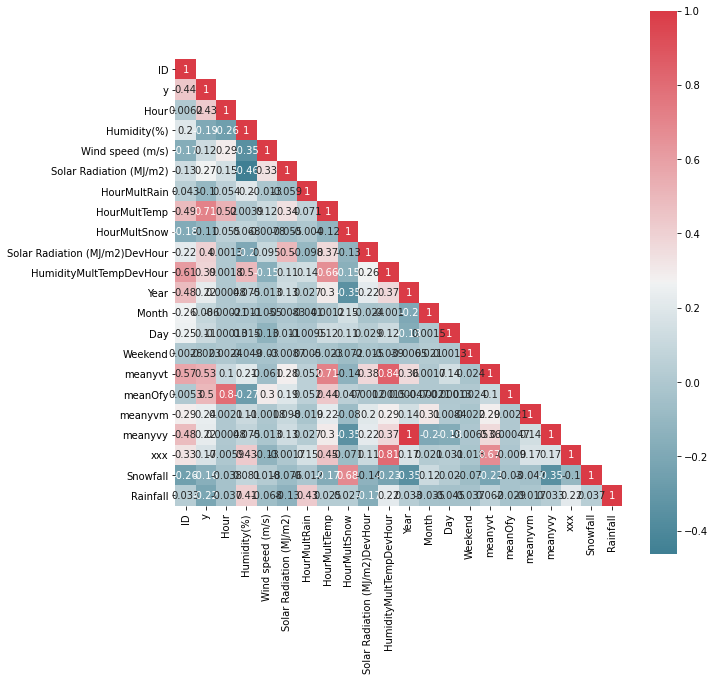

In [33]:
corr = df.corr()
corr_mask = np.ones_like(corr)
corr_mask[np.tril_indices_from(corr_mask)] = False

plt.subplots(figsize=(10,10))
sns.heatmap(corr, mask=corr_mask, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, annot=True)
plt.show()

Test Data

In [34]:
df_test["Visibility"]=df_test['Visibility (10m)'].apply(lambda x : 1 if (x >650) else(0))
df_test.drop(columns=['Visibility (10m)'], inplace=True)


# df_test["Humidity"]=df_test['Humidity(%)'].apply(lambda x : 0 if (x > 35 and x < 75) else(1))
# df_test.drop(columns=['Humidity(%)'], inplace=True)


df_test["Snowfall"]=df_test['Snowfall (cm)'].apply(lambda x : 1 if (x > 0) else(0))
df_test.drop(columns=['Snowfall (cm)'], inplace=True)

df_test['Rainfall']=df_test['Rainfall(mm)'].apply(lambda x : 1 if (x > 0) else(0))
df_test.drop(columns=['Rainfall(mm)'], inplace=True)





In [35]:
enc_df_test = df_test[enc_col_names]
df_test.drop(enc_col_names, inplace=True, axis=1)
# enc_df_test.head()

In [36]:
# Ordinal Encoding
ord_enc_test = preprocessing.OrdinalEncoder(dtype=int)
ord_enc_df_test = pd.DataFrame(ord_enc_test.fit_transform(enc_df_test), columns= enc_col_names)
# ord_enc_df_test.head()

In [37]:
df_test_using_ord_enc = pd.concat([df_test, ord_enc_df_test], axis=1)

RMSLE function

In [38]:
def rmsle(y_pred, y_test) : 
    assert len(y_test) == len(y_pred)
    return np.sqrt(np.mean((np.log(1+y_pred) - np.log(1+y_test))**2))

# Model Training

In [39]:
#Split The Data (Ordinal Encoded)
X, y = df_using_ord_enc.drop(columns = ["ID", "y"]), df_using_ord_enc["y"]
X_train_ord, X_test_ord, y_train_ord, y_test_ord = train_test_split(X, y, random_state=0, test_size=0.2)

In [40]:
models = [ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor]
param = {
    "extra_reg_model" : { "n_estimators":100, "random_state":0},
    "grad_bo_reg_model" : {"max_depth":5, "min_samples_leaf":3, "n_estimators":100, "learning_rate":0.2, "max_features":5, "random_state":0},
    "ran_for_reg_model" : { "n_estimators" : 100, "random_state" : 0},
#     "dec_tree_reg_model" : {  "random_state" : 0},
    "bag_reg_model" : { "n_estimators" : 100, "random_state" : 0}
    
}
model_fit_ord = {}
model_fit_one = {}

In [41]:
for model, param_key in zip(models,param):
    # Ordinal Encoding
    model_res = model(**param[param_key]).fit(X_train_ord, y_train_ord)
    print(f"Score of {param_key}_ord = {model_res.score(X_test_ord, y_test_ord)}")
    print(f"Score of {param_key}_ord = {model_res.score(X_train_ord, y_train_ord)}")
    
    y_pred = model_res.predict(X_test_ord) #* X_test_ord["Functioning Day"]
    y_pred_train = model_res.predict(X_train_ord) #* X_train_ord["Functioning Day"]
    
    print(f"RMSLE of {param_key}_ord (train) = {rmsle(y_train_ord, y_pred_train)}")
    print(f"RMSLE of {param_key}_ord = {rmsle(y_test_ord, y_pred)}\n\n")
    
    model_fit_ord[param_key+"_ord"] = model_res
  

Score of extra_reg_model_ord = 0.8989147012381501
Score of extra_reg_model_ord = 1.0
RMSLE of extra_reg_model_ord (train) = 0.0
RMSLE of extra_reg_model_ord = 0.4201224452301492


Score of grad_bo_reg_model_ord = 0.9053950266437858
Score of grad_bo_reg_model_ord = 0.9607087477454299
RMSLE of grad_bo_reg_model_ord (train) = 0.38799043871716493
RMSLE of grad_bo_reg_model_ord = 0.47001986470579044




/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


Score of ran_for_reg_model_ord = 0.8978883250276095
Score of ran_for_reg_model_ord = 0.9844728594868448
RMSLE of ran_for_reg_model_ord (train) = 0.251658613724236
RMSLE of ran_for_reg_model_ord = 0.4719387686432116


Score of bag_reg_model_ord = 0.8976656800604269
Score of bag_reg_model_ord = 0.9844382404556951
RMSLE of bag_reg_model_ord (train) = 0.25138172924284835
RMSLE of bag_reg_model_ord = 0.47268874958709245




In [42]:
my_ord_model = XGBRegressor(eval_metric="rmsle", max_depth=5, n_estimators=196, objective='count:poisson').fit(X_train_ord, y_train_ord,early_stopping_rounds=20, 
             eval_set=[(X_test_ord, y_test_ord)], verbose=False)
print(f"Score of XGB_reg_model_ord = {my_ord_model.score(X_test_ord, y_test_ord)}")
print(f"Score of XGB_reg_model_ord = {my_ord_model.score(X_train_ord, y_train_ord)}")

y_pred = my_ord_model.predict(X_test_ord) #* X_test_ord["Functioning Day"]
y_pred_train = my_ord_model.predict(X_train_ord) #* X_train_ord["Functioning Day"]

print(f"RMSLE of XGB_reg_model_ord (train)= {rmsle(y_train_ord, y_pred_train)}")
print(f"RMSLE of XGB_reg_model_ord = {rmsle(y_test_ord, y_pred)}\n\n")

model_fit_ord["XGB_reg_model"+"_ord"] = my_ord_model

Score of XGB_reg_model_ord = 0.919410815724116
Score of XGB_reg_model_ord = 0.9795587995952071
RMSLE of XGB_reg_model_ord (train)= 0.24043802272390183
RMSLE of XGB_reg_model_ord = 0.38080216530839384




# Submission File Generation

# Apply models on Ordinal Encoding Data

In [43]:
y_test_pred = {}
func = df_test_using_ord_enc["Functioning Day"] == "Yes"



X_test_ord = df_test_using_ord_enc.drop(columns = ["ID", "Functioning Day"])

for key in model_fit_ord :
    y_test_pred[key] = model_fit_ord[key].predict(X_test_ord) * func


In [44]:
df_test_using_ord_enc["y"] = y_test_pred["XGB_reg_model_ord"]


In [45]:
y_test_pred["XGB_reg_model_ord"]

0       115.113686
1       102.718605
2        85.782143
3        56.982986
4        34.905064
           ...    
2995    966.076355
2996    942.674500
2997    851.268005
2998    767.932251
2999    661.277771
Name: Functioning Day, Length: 3000, dtype: float32

In [46]:
df_test_using_ord_enc[['ID', 'y']].to_csv('/kaggle/working/submission.csv', index=False)